In [15]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
import math

In [16]:
## 更改根目录
import os
os.chdir('/kaggle/input/intel-image-classification')
os.getcwd()

'/kaggle/input/intel-image-classification'

In [17]:
## 训练集和测试集路径
train_dir='seg_train/seg_train/'
test_dir='seg_test/seg_test/'

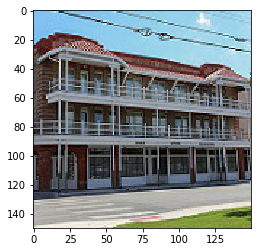

In [18]:
import sys
from tqdm import tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np
from skimage import color
from skimage.transform import resize
from sklearn.utils import shuffle
from sklearn.decomposition import PCA
import tensorflow as tf
%matplotlib inline
img_path='buildings/1001.jpg'
image=img.imread(os.path.join(train_dir, img_path))
plt.imshow(image)
plt.show()

In [19]:
# 读数据
train_X, train_Y = [], []     # train_X(训练集数据集X)，train_Y(训练集目标值Y);
test_X, test_Y = [], []       # test_X(测试集数据集X)，test_Y(测试集目标值Y);
IMG_HEIGHT = IMG_WIDTH = 100  # 图像尺寸为IMG_HEIGHT，IMG_WIDTH

# 建立生成器取得批量数据
sys.stdout.flush()
train_folders = next(os.walk(train_dir))[1]
test_folders = next(os.walk(test_dir))[1]

print('开始读取训练集图像文件...')
for folder in train_folders:
    PATH = os.path.join(train_dir, folder)
    train_imgs = os.listdir(PATH)
    print('读取文件夹' + folder)
    for n, id_ in tqdm(enumerate(train_imgs), total = len(train_imgs)):
        train_img_path=os.path.join(PATH, id_)
        I=img.imread(train_img_path)
        # 图像裁剪
        cropped_img= resize(I, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        train_X.append(cropped_img)
        train_Y.append(folder)
    print('文件夹'+folder+'读取完成!\n')
print('训练集图像文件读取完成!!!\n')

print('开始读取测试集图像文件...')
for folder in test_folders:
    PATH=os.path.join(test_dir,folder)
    test_imgs=os.listdir(PATH)
    print('读取文件夹'+folder)
    for n, id_ in tqdm(enumerate(test_imgs), total=len(test_imgs)):
    # for id_ in test_imgs:
        test_img_path=os.path.join(PATH,id_)
        I=img.imread(test_img_path)
        ## 图像裁剪
        cropped_img= resize(I, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        test_X.append(cropped_img)
        test_Y.append(folder)
    print('文件夹'+folder+'读取完成!\n')
print('测试集图像文件读取完成!!!')



  1%|          | 24/2404 [00:00<00:09, 239.23it/s]

开始读取训练集图像文件...
读取文件夹glacier


  1%|          | 28/2274 [00:00<00:08, 274.68it/s]

文件夹glacier读取完成!

读取文件夹sea


  1%|          | 28/2382 [00:00<00:08, 271.82it/s]

文件夹sea读取完成!

读取文件夹street


  1%|          | 28/2512 [00:00<00:09, 274.96it/s]

文件夹street读取完成!

读取文件夹mountain


  1%|          | 24/2191 [00:00<00:09, 239.84it/s]

文件夹mountain读取完成!

读取文件夹buildings


  1%|          | 27/2271 [00:00<00:08, 258.06it/s]

文件夹buildings读取完成!

读取文件夹forest


  5%|▍         | 27/553 [00:00<00:01, 268.29it/s]

文件夹forest读取完成!

训练集图像文件读取完成!!!

开始读取测试集图像文件...
读取文件夹glacier


  5%|▌         | 27/510 [00:00<00:01, 264.82it/s]

文件夹glacier读取完成!

读取文件夹sea


  5%|▍         | 25/501 [00:00<00:01, 249.10it/s]

文件夹sea读取完成!

读取文件夹street


  5%|▌         | 27/525 [00:00<00:01, 261.73it/s]

文件夹street读取完成!

读取文件夹mountain


  6%|▌         | 26/437 [00:00<00:01, 253.43it/s]

文件夹mountain读取完成!

读取文件夹buildings


  5%|▌         | 26/474 [00:00<00:01, 257.88it/s]

文件夹buildings读取完成!

读取文件夹forest


100%|██████████| 474/474 [00:01<00:00, 249.91it/s]

文件夹forest读取完成!

测试集图像文件读取完成!!!


In [20]:
# 打印训练集和测试大小
print(len(train_X), len(train_Y), len(test_X), len(test_Y))

14034 14034 3000 3000


In [21]:
# 独热编码转换
# 标签train_Y,test_Y转为one_hot coding(独热编码)
map_dic={'buildings':[1,0,0,0,0,0],'forest':[0,1,0,0,0,0],\
        'glacier':[0,0,1,0,0,0],'mountain':[0,0,0,1,0,0],\
        'sea':[0,0,0,0,1,0],'street':[0,0,0,0,0,1]}

train_Y_one_hot=np.array([map_dic[e] for e in train_Y])
test_Y_one_hot=np.array([map_dic[e] for e in test_Y])
train_X = np.array(train_X, dtype=np.int32)
test_X = np.array(test_X)

del train_Y,test_Y

print("训练集X尺寸",train_X.shape)
print("训练集Y尺寸",train_Y_one_hot.shape)
print("测试集X尺寸",test_X.shape)
print("测试集Y尺寸",test_Y_one_hot.shape)


训练集X尺寸 (14034, 100, 100, 3)
训练集Y尺寸 (14034, 6)
测试集X尺寸 (3000, 100, 100, 3)
测试集Y尺寸 (3000, 6)


In [22]:
# 打乱数据
train_X_shuffle, train_Y_shuffle = shuffle(train_X, train_Y_one_hot)
del train_X, train_Y_one_hot
test_X_shuffle, test_Y_shuffle = shuffle(test_X, test_Y_one_hot)
del test_X, test_Y_one_hot

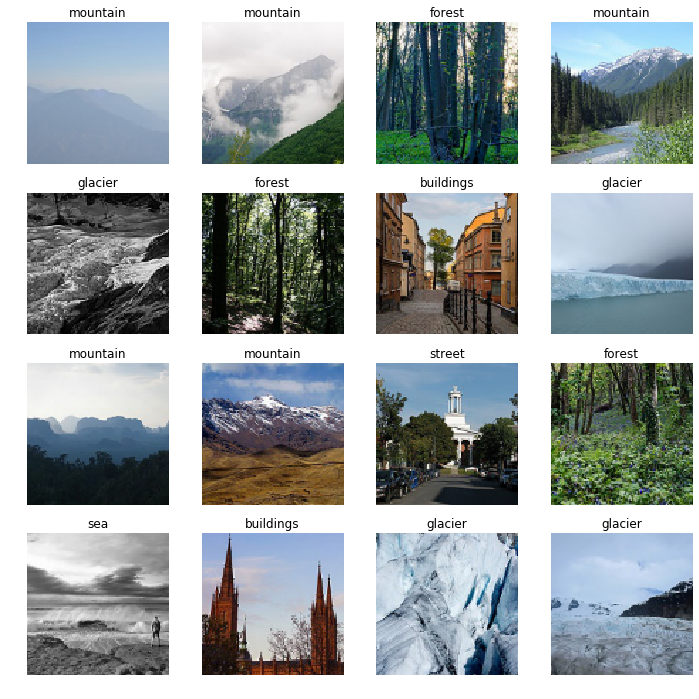

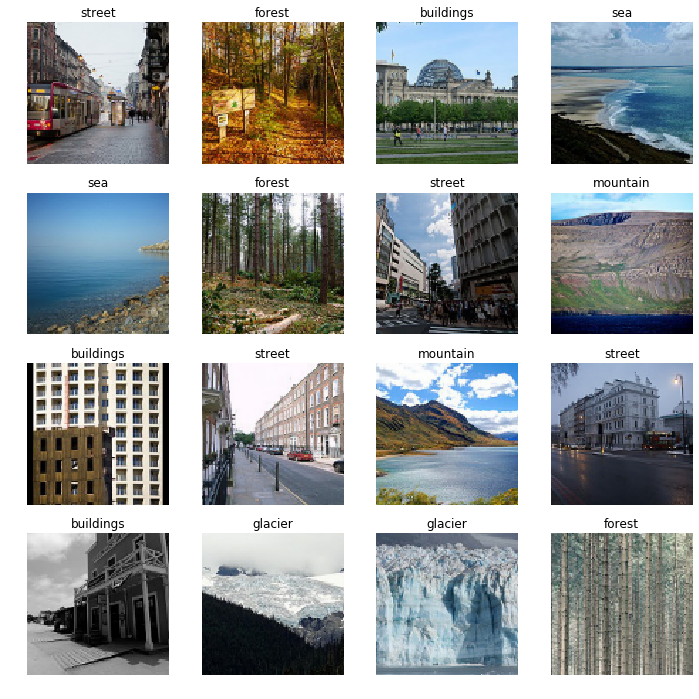

In [23]:
def ret_label(one_hot_list):
    '''给定一个独热编码后的列表，返回map_dic的键，如输入[1, 0, 0, 0, 0, 0]，返回building'''
    for _ in map_dic.items():
        if one_hot_list in _:
            return (_[0])

def show(img,label):
    '''给定numpy数组类型的图像，和标签label，作可视化'''
    fig=plt.figure(figsize=(12,12))
    for i in range(16):
        plt.subplot(4,4,i+1)
        plt.imshow(img[i].astype(np.uint8))
        plt.title("{0}".format(ret_label(label[i].tolist())))
        plt.axis('off')
    plt.show()
    
show(train_X_shuffle, train_Y_shuffle)
show(test_X_shuffle, test_Y_shuffle)

In [24]:
def gen_small_data(inputs, Labels, batch_size):
    st = 0
    while True:
        ed = min(st + batch_size, inputs.shape[0])
        small_data = inputs[st : ed]
        small_label = Labels[st : ed]
        st += batch_size
        yield small_data, small_label

In [25]:
import time
EPOCHS = 20                      # 用全部数据训练一次的数量（周期，纪元）
BATCH_SIZE = 32                  # 一个batch的大小
LEARNING_RATE_BASE = 0.1         # 基础学习率
LEARNING_RATE_DACAY = 0.99       # 学习率的衰减率
REGULARIZATION_RATE = 0.0001     # 模型复杂度的正则化项在损失函数中的系数
TRAINING_STEPS = 10000            # 训练次数
MOVING_AVERAGE_DECAY = 0.99      # 滑动平均衰减率
BATCH_NUM = math.ceil(train_X_shuffle.shape[0] / BATCH_SIZE) # 块的数目
NUM_OUTPUT_NODE = 6 # 6 输出种类数

image_size = IMG_HEIGHT        # 图像大小
image_channels = 3               # 图像通道数

# 第一层卷积层的尺寸和深度
conv1_size = 3
conv1_deep = 200
    
# 第二层卷积层的尺寸和深度
conv2_size = 3
conv2_deep = 180
    
# 第三层卷积层的尺寸和深度
conv3_size = 3
conv3_deep = 140
    
# 第四层卷积层的尺寸和深度
conv4_size = 3
conv4_deep = 100

# # 第五层卷积层的尺寸和深度
# conv5_size = 3
# conv5_deep = 50

# 全连接层结点数
fc_size = 128

In [26]:
def cnn (input_tensor):
    """
    input_tensor: 神经网络的输入张量
    avg_class: 滑动平均类
    """
    
    # 第一层卷积层
    conv1_w = tf.Variable(tf.truncated_normal(shape = [conv1_size, conv1_size, image_channels, conv1_deep], stddev=0.1))
    conv1_b = tf.Variable(tf.truncated_normal(shape = [conv1_deep], stddev = 0.1))
    conv1 = tf.nn.conv2d(input_tensor, conv1_w, strides=[1,1,1,1], padding='SAME')
    relu1 = tf.nn.relu(tf.nn.bias_add(conv1, conv1_b))

    # 第二层卷积层
    conv2_w = tf.Variable(tf.truncated_normal(shape = [conv2_size, conv2_size, conv1_deep, conv2_deep], stddev=0.1))
    conv2_b = tf.Variable(tf.truncated_normal(shape = [conv2_deep], stddev = 0.1))
    conv2 = tf.nn.conv2d(conv1, conv2_w, strides=[1,1,1,1], padding='SAME')
    relu2 = tf.nn.relu(tf.nn.bias_add(conv2, conv2_b))
    
    # 池化层
    pool1 = tf.nn.max_pool(relu2, ksize=[1,5,5,1], strides=[1,5,5,1], padding='SAME')
    
    # 第三层卷积层
    conv3_w = tf.Variable(tf.truncated_normal(shape = [conv3_size, conv3_size, conv2_deep, conv3_deep], stddev=0.1))
    conv3_b = tf.Variable(tf.truncated_normal(shape = [conv3_deep], stddev = 0.1))
    conv3 = tf.nn.conv2d(pool1, conv3_w, strides=[1,1,1,1], padding='SAME')
    relu3 = tf.nn.relu(tf.nn.bias_add(conv3, conv3_b))
    
    # 第四层卷积层
    conv4_w = tf.Variable(tf.truncated_normal(shape = [conv4_size, conv4_size, conv3_deep, conv4_deep], stddev=0.1))
    conv4_b = tf.Variable(tf.truncated_normal(shape = [conv4_deep], stddev = 0.1))
    conv4 = tf.nn.conv2d(conv3, conv4_w, strides=[1,1,1,1], padding='SAME')
    relu4 = tf.nn.relu(tf.nn.bias_add(conv4, conv4_b))
    
#     # 第五层卷积层
#     conv5_w = tf.Variable(tf.truncated_normal(shape = [conv5_size, conv5_size, conv4_deep, conv5_deep], stddev=0.1))
#     conv5_b = tf.Variable(tf.truncated_normal(shape = [conv5_deep], stddev = 0.1))
#     conv5 = tf.nn.conv2d(conv4, conv5_w, strides=[1,1,1,1], padding='SAME')
#     relu5 = tf.nn.relu(tf.nn.bias_add(conv5, conv5_b))
    
    # 池化层
    pool2 = tf.nn.max_pool(relu4, ksize=[1,5,5,1], strides=[1,5,5,1], padding='SAME')
    
    # 把矩阵拉直成向量
    vector = tf.layers.Flatten()(pool2)
    
    return vector

    
def forward(vector, avg_class, fc1_w, fc1_b, fc2_w, fc2_b):
    # 全连接层 两层
    if avg_class:
        fc1 = tf.nn.relu(tf.matmul(vector, avg_class.average(fc1_w)) + avg_class.average(fc1_b))
        output_layer = tf.matmul(fc1, avg_class.average(fc2_w)) + avg_class.average(fc2_b)
    else:
        fc1 = tf.nn.relu(tf.matmul(vector, fc1_w) + fc1_b)
        output_layer = tf.matmul(fc1, fc2_w) + fc2_b
    return output_layer

In [27]:
# 输入占位符
x_ = tf.placeholder(tf.float32, [None, image_size, image_size, image_channels], name='x-input')
y_ = tf.placeholder(tf.float32, [None, NUM_OUTPUT_NODE], name = 'y-input')

vector = cnn(x_)
vec_shape = vector.get_shape().as_list()

# 全连接层 两层
fc1_w = tf.Variable(tf.truncated_normal(shape = [vec_shape[1], fc_size], stddev = 0.1))
fc1_b = tf.Variable(tf.truncated_normal(shape = [fc_size], stddev = 0.1))
fc2_w = tf.Variable(tf.truncated_normal(shape = [fc_size, NUM_OUTPUT_NODE], stddev = 0.1))
fc2_b = tf.Variable(tf.truncated_normal(shape = [NUM_OUTPUT_NODE], stddev = 0.1))

# 没有指定滑动平均类的前向传输结果
y = forward(vector, None, fc1_w, fc1_b, fc2_w, fc2_b) 

global_step = tf.Variable(0, trainable=False)
variable_averages = tf.train.ExponentialMovingAverage(MOVING_AVERAGE_DECAY, global_step)
variable_averages_op = variable_averages.apply(tf.trainable_variables())
    
# 有使用了滑动平均的前向传输结果
average_y = forward(vector, variable_averages, fc1_w, fc1_b, fc2_w, fc2_b)

# 交叉熵
cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits = y, labels = tf.argmax(y_, 1))

# 所有交叉熵平均值
cross_entropy_mean = tf.reduce_mean(cross_entropy)

# L2正则化损失函数
regularizer = tf.contrib.layers.l2_regularizer(REGULARIZATION_RATE) 

# 模型的正则化损失
regularization = regularizer(fc1_w) + regularizer(fc2_w) 

# loss function 总损失
loss = cross_entropy_mean + regularization

train_step = tf.train.AdamOptimizer().minimize(loss)

train_op = tf.group(train_step, variable_averages_op)

correct_prediction = tf.equal(tf.argmax(average_y, 1), tf.argmax(y_, 1))

accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [29]:
# 开始训练过程
saver = tf.train.Saver()
step, ac_tr, ac_v, ac_te = [], [], [], []
epoch_num, ac_test = [], []
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    idx = 1
    for i in range(EPOCHS):
        # 开始一轮epochs训练
        print('Epoch:', i + 1)
        
        train_data_batch = gen_small_data(train_X_shuffle, train_Y_shuffle, BATCH_SIZE)
        test_data_batch = gen_small_data(test_X_shuffle, test_Y_shuffle, BATCH_SIZE)
        for j in range(BATCH_NUM):
            train_x_batch, train_y_batch = next(train_data_batch)
            test_x_batch, test_y_batch = next(test_data_batch)
            if test_x_batch.shape[0] == 0:
                test_data_batch = gen_small_data(test_X_shuffle, test_Y_shuffle, BATCH_SIZE)
                test_x_batch, test_y_batch = next(test_data_batch)

            train_batch_feed = {x_: train_x_batch, y_: train_y_batch}
            test_batch_feed = {x_: test_x_batch, y_: test_y_batch}

            sess.run(train_op, feed_dict = train_batch_feed)
            
            if (j + 1) % 50 == 0:
                train_batch_acc = sess.run(accuracy, feed_dict = train_batch_feed)
                test_batch_acc = sess.run(accuracy, feed_dict = test_batch_feed)
                print('batch号码：{}, 这个batch的训练集准确率为：{}, 这个batch的测试集准确率为：{}'
                      .format(j+1, train_batch_acc, test_batch_acc))
                step.append(idx)
                idx += 1
                ac_tr.append(train_batch_acc)
                ac_te.append(test_batch_acc)
                
        test_acc = 0
        for k in range(5):
            st = k * 600
            ed = st + 600
            test_acc_i = sess.run(accuracy, feed_dict = {x_: test_X_shuffle[st:ed], y_: test_Y_shuffle[st:ed]})
            test_acc += test_acc_i
            
        print('这轮训练完，测试集准确率为：', test_acc / 5)
        epoch_num.append(i+1)
        ac_test.append(test_acc)
    
#     saver.save(sess,'intelimage_model_cnn.ckpt')
#     print('模型保存完成！')


Epoch: 1
batch号码：50, 这个batch的训练集准确率为：0.5625, 这个batch的测试集准确率为：0.46875
batch号码：100, 这个batch的训练集准确率为：0.40625, 这个batch的测试集准确率为：0.4375
batch号码：150, 这个batch的训练集准确率为：0.5625, 这个batch的测试集准确率为：0.5625
batch号码：200, 这个batch的训练集准确率为：0.53125, 这个batch的测试集准确率为：0.5
batch号码：250, 这个batch的训练集准确率为：0.375, 这个batch的测试集准确率为：0.53125
batch号码：300, 这个batch的训练集准确率为：0.4375, 这个batch的测试集准确率为：0.4375
batch号码：350, 这个batch的训练集准确率为：0.40625, 这个batch的测试集准确率为：0.40625
batch号码：400, 这个batch的训练集准确率为：0.46875, 这个batch的测试集准确率为：0.46875
这轮训练完，测试集准确率为： 0.431333327293396
Epoch: 2
batch号码：50, 这个batch的训练集准确率为：0.25, 这个batch的测试集准确率为：0.46875
batch号码：100, 这个batch的训练集准确率为：0.375, 这个batch的测试集准确率为：0.28125
batch号码：150, 这个batch的训练集准确率为：0.46875, 这个batch的测试集准确率为：0.34375
batch号码：200, 这个batch的训练集准确率为：0.21875, 这个batch的测试集准确率为：0.40625
batch号码：250, 这个batch的训练集准确率为：0.375, 这个batch的测试集准确率为：0.34375
batch号码：300, 这个batch的训练集准确率为：0.3125, 这个batch的测试集准确率为：0.21875
batch号码：350, 这个batch的训练集准确率为：0.125, 这个batch的测试集准确率为：0.25
batch号码：400, 这个batch的训练集准确率为：0.40625, 这个batch的

batch号码：350, 这个batch的训练集准确率为：0.53125, 这个batch的测试集准确率为：0.5
batch号码：400, 这个batch的训练集准确率为：0.71875, 这个batch的测试集准确率为：0.71875
这轮训练完，测试集准确率为： 0.622000002861023
Epoch: 17
batch号码：50, 这个batch的训练集准确率为：0.6875, 这个batch的测试集准确率为：0.75
batch号码：100, 这个batch的训练集准确率为：0.75, 这个batch的测试集准确率为：0.59375
batch号码：150, 这个batch的训练集准确率为：0.78125, 这个batch的测试集准确率为：0.71875
batch号码：200, 这个batch的训练集准确率为：0.78125, 这个batch的测试集准确率为：0.625
batch号码：250, 这个batch的训练集准确率为：0.59375, 这个batch的测试集准确率为：0.75
batch号码：300, 这个batch的训练集准确率为：0.5, 这个batch的测试集准确率为：0.46875
batch号码：350, 这个batch的训练集准确率为：0.625, 这个batch的测试集准确率为：0.46875
batch号码：400, 这个batch的训练集准确率为：0.65625, 这个batch的测试集准确率为：0.6875
这轮训练完，测试集准确率为： 0.7193333268165588
Epoch: 18
batch号码：50, 这个batch的训练集准确率为：0.75, 这个batch的测试集准确率为：0.625
batch号码：100, 这个batch的训练集准确率为：0.75, 这个batch的测试集准确率为：0.5625
batch号码：150, 这个batch的训练集准确率为：0.875, 这个batch的测试集准确率为：0.84375
batch号码：200, 这个batch的训练集准确率为：0.71875, 这个batch的测试集准确率为：0.65625
batch号码：250, 这个batch的训练集准确率为：0.75, 这个batch的测试集准确率为：0.6875
batch号码：300, 这个batch的训练

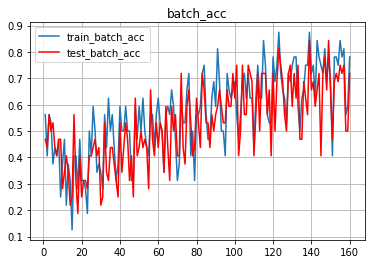

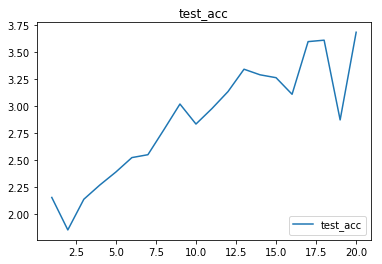

In [36]:
import matplotlib.pyplot as plt
plt.plot(step, ac_tr)
plt.plot(step, ac_te, c='red')
plt.grid()
plt.legend(["train_batch_acc", "test_batch_acc"])
plt.title('batch_acc')
plt.show()

plt.plot(epoch_num, ac_test)
plt.legend(['test_acc'], loc = 'lower right')
plt.title('test_acc')
plt.show()